# Task instructions (please read carefully)

- Allocate up to 4 hours to work on these tasks.
- To solve the task, first make a copy of this notebook by clicking in the top-left "File" -> “Save a copy in Drive”. Then solve the task on a standard GPU instance in colab.research.google.com.
- To setup the GPU instance runtime, in top bar click "runtime" -> "change runtime type" -> "T4 GPU" (under Hardware accelerator). Note that this instance is free, i.e. no money will be billed to your Google account.
- Use any tools available to you, including existing libraries, LLMs, coding assistants, etc. To install a library in colab, you can use `!pip install <library_name>` in the top cell.
- Some of the tasks are very hard, and it is not expected for all candidates to solve them.
- For all optimization processes (training, SDS optimization, ...), make sure to log the optimized objectives and display graphs displaying their convergence.
- Besides the correctness of the solutions, we will also assess the code quality.

### Submission:
- Once done with solving the tasks -> click “Share” in top-right -> under “General access” select “Anyone with the link” -> click “Copy link” -> paste the link to the submission form.
- Together with sharing the link, download the .ipynb file and upload the file into the submission form.
- Before time runs out, please write a paragraph about the things you tried, what worked and what didn't, how did you debug it, and what would you do if you had more time. Please write this as a text cell directly inside the notebook.
- Before submitting, make sure that your colab runs from beginning to end on a standard GPU instance in [colab.research.google.com](colab.research.google.com).

Good luck!

# Machine Learning Take-Home Exercise: Diffusion Models and Inpainting

In this exercise, you will:
1. Implement a simple diffusion model and train it on the MNIST dataset
2. Use the trained model to perform image inpainting
3. Use the trained model to perform image inpainting using SDS optimization

## Part 1: Implementing a Simple Diffusion Model

First, let's import the necessary libraries and set up our environment.

In [ ]:
# !conda create -n spAItial python=3.9
# !conda activate spAItia
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install tqdm
# !pip install matplotlib
# !pip install asttokens
# !pip install decorator
# !pip install ipywidgets

In [ ]:
import os
import torch
import random
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import typing
import torchvision
from tqdm.auto import tqdm


import math
import numpy as np
import torch.nn.functional as F

if not torch.cuda.is_available():
    raise RuntimeError("No GPU found. Make sure to select a GPU runtime in the Colab instance settings.")

device = torch.device('cuda')

### 1.1 Data Loading

We'll use MINST dataset. We setup the data loader to load small (16x16) images, so that we can train a small diffusion model in this dataset quickly.

In [15]:
NUM_CLASSES = 10  # the number of digit classes in the MNIST dataset
H, W = 16, 16  # the height and width of the input images

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((H, W)),
    transforms.Normalize((0.5,), (0.5,)),
])

trainset = torchvision.datasets.MNIST(
    root='./data_take_home_minst', train=True,
    download=True, transform=transform
)
valset = torchvision.datasets.MNIST(
    root='./data_take_home_minst', train=False,
    download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False, num_workers=0)

torch.Size([128, 1, 16, 16])


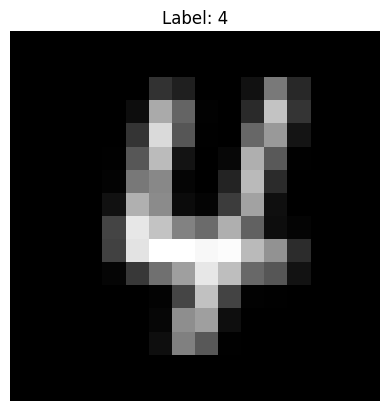

In [16]:
# Visualize inputs to avoid random garbage from dataloader, always saves you a headache
for batch in trainloader:
    imgs = batch[0]
    labels = batch[1]
    print(imgs.shape)
    plt.imshow(imgs[0,0], cmap='gray')
    plt.title(f"Label: {labels[0]}")
    plt.axis('off')  # Hide axes for clarity
    plt.show()
    break

### 1.2 Implementing the Model

Complete the Model implementation below. This will be our noise prediction network.

NOTE:
- In the following cells, feel free to add any additional parameters you need into the function signatures.
- A succesful diffusion model can be trained within 15 minutes with a model containing ~30M parameters.

In [69]:
import math

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, theta = 10000):
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

# helper: simple embedding for discrete classes
class ClassEmbedding(nn.Module):
    def __init__(self, num_classes, embedding_dim=64):
        super().__init__()
        self.embed = nn.Embedding(num_classes, embedding_dim)
    def forward(self, y):
        return self.embed(y)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, class_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.temb_proj = nn.Linear(time_emb_dim, out_channels)
        self.cemb_proj = nn.Linear(class_emb_dim, out_channels)
        self.activation = nn.SiLU()
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x, t_emb, c_emb):
        """
        x: shape (B, in_channels, H, W)
        t_emb, c_emb: shape (B, embed_dim) - to be injected
        """
        # project embeddings to channel dimension
        temb = self.temb_proj(t_emb)[:, :, None, None]
        cemb = self.cemb_proj(c_emb)[:, :, None, None]

        h = self.conv1(x)
        h = h + temb + cemb
        h = self.activation(h)

        h = self.conv2(h)
        h = self.activation(h)

        return h + self.shortcut(x)

class Model(nn.Module):
    def __init__(self, num_classes=10, base_channels=256, time_emb_dim=256, n_resblocks=8):
        super().__init__()

        self.time_emb_dim = time_emb_dim
        self.class_emb_dim = time_emb_dim   # for simplicity, use same dim for class
        sinu_pos_emb = SinusoidalPosEmb(time_emb_dim)

        time_dim = time_emb_dim * 1
        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(time_emb_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        self.class_embed = ClassEmbedding(num_classes, self.class_emb_dim)

        # self.initial_conv = nn.Conv2d(1, base_channels, kernel_size=3, padding=1)
        self.initial_conv = nn.Sequential(
            nn.Conv2d(1, base_channels//8, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(base_channels//8, base_channels//4, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(base_channels//4, base_channels//2, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(base_channels//2, base_channels, kernel_size=3, padding=1),
        )

        # Instead of hardcoding res1/res2/res3, do this:
        self.res_blocks = nn.ModuleList([
            ResidualBlock(base_channels, base_channels, time_emb_dim, time_emb_dim)
            for _ in range(n_resblocks)
        ])

        # self.final_conv = nn.Conv2d(base_channels, 1, kernel_size=3, padding=1)
        self.final_conv = nn.Sequential(
            nn.Conv2d(base_channels, base_channels//2, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(base_channels//2, base_channels//4, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(base_channels//4, base_channels//8, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(base_channels//8, 1, kernel_size=3, padding=1),
        )

        self.activation = nn.SiLU()

    def forward(self, x: torch.Tensor, t: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input image, a float tensor of shape (batch_size, in_channels, H, W)
            t: the timestep, a long tensor of shape (batch_size,)
            y: the class label, a long tensor of shape (batch_size,)
        """
        # 1. Time embedding
        t_emb = self.time_mlp(t)       # shape (B, time_emb_dim)

        # 2. Class embedding
        c_emb = self.class_embed(y)    # shape (B, class_emb_dim)

        # 3. Input projection
        h = self.initial_conv(x)  # (B, base_channels, 16, 16)

        # 4. Residual blocks with embedding injection
        for resblk in self.res_blocks:
            h = resblk(h, t_emb, c_emb)

        # 5. Final projection
        h = self.final_conv(h)
        return h


In [75]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
               
model_ = Model(base_channels=512, time_emb_dim=64, n_resblocks=6)
print(f'Parameters count {count_parameters(model_)}')
x = torch.randn(8, 1, 28, 28)
t = torch.tensor([0])
y = torch.tensor([0])
print(f'Model input shape x={x.shape}')
print(f'Model input shape t={t.shape}')
print(f'Model input shape y={y.shape}')
print(f'Model output shape eps_pred={model_(x=torch.randn(8, 1, 28, 28), t=torch.tensor([0]), y=torch.tensor([0])).shape}')

print('\nModel summary:')
print(model_)

Parameters count 33401089
Model input shape x=torch.Size([8, 1, 28, 28])
Model input shape t=torch.Size([1])
Model input shape y=torch.Size([1])
Model output shape eps_pred=torch.Size([8, 1, 28, 28])

Model summary:
Model(
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=64, out_features=64, bias=True)
  )
  (class_embed): ClassEmbedding(
    (embed): Embedding(10, 64)
  )
  (initial_conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SiLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): SiLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): SiLU()
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (res_blocks): ModuleList(
    (0-5): 6 x ResidualBlock(
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), s

### 1.3 Training Loop

First, implement the forward diffusion process and the loss computation.

Then, implement the training loop for the diffusion model.

Once done, train the model to convergence in order to be able to sample images of digits from the MNIST dataset.

In [60]:
import numpy as np
import torch.nn.functional as F

# Define the number of DDPM steps and compute alpha and beta schedules
T = 1000  
beta_start = 1e-4
beta_end   = 2e-2
beta_np = np.linspace(beta_start, beta_end, T, dtype=np.float32)

beta_torch = torch.tensor(beta_np, device=device)
alpha_torch = 1. - beta_torch
alpha_bar_torch = torch.cumprod(alpha_torch, dim=0)


# def cosine_beta_schedule(timesteps, s=0.008):
#     """
#     Cosine schedule as proposed in 
#     'Improved Denoising Diffusion Probabilistic Models' (Nichol & Dhariwal, 2021).
#     s is a small offset to prevent beta from being too large near t=0.
    
#     Returns:
#       np.array of betas of length `timesteps`.
#     """
#     # The paper defines alpha_bar(t), and beta_t is the discrete difference of alpha_bar.
#     steps = timesteps + 1
#     x = np.linspace(0, timesteps, steps, dtype=np.float64)

#     # define alpha_bar using cosine
#     alphas_cumprod = np.cos(
#         ((x / timesteps) + s) / (1 + s) * math.pi * 0.5
#     ) ** 2
#     # normalize so that alpha_bar(0) = 1
#     alphas_cumprod = alphas_cumprod / alphas_cumprod[0]

#     # now create the betas
#     # beta_t = 1 - alpha_bar_t / alpha_bar_{t-1}
#     betas = []
#     for i in range(timesteps):
#         alpha_bar_t   = alphas_cumprod[i+1]
#         alpha_bar_t_1 = alphas_cumprod[i]
#         beta_t = 1.0 - (alpha_bar_t / alpha_bar_t_1)
#         betas.append(beta_t)
#     return np.array(betas, dtype=np.float32)


# ########################################
# # Example usage: Replacing your linear schedule with cosine
# ########################################

# T = 1000

# # get the betas from the cosine scheduler
# beta_np = cosine_beta_schedule(T, s=0.008)

# # convert them to torch
# beta_torch = torch.tensor(beta_np, device=device)   # shape (T,)
# alpha_torch = 1. - beta_torch                       # alpha = 1 - beta
# alpha_bar_torch = torch.cumprod(alpha_torch, dim=0) # \prod_{i=1}^t alpha_i

# # now alpha_bar_torch[t] is \bar{alpha}_t, which you can use in diffusion_forward

In [61]:
def diffusion_forward(x_0: torch.Tensor, t: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
    """
    Forward diffusion process, given a clean image x_0 and a timestep t,
    returns the noised image and the noise.
    """
    # t is in [0, T-1], so alpha_bar[t] is shape (B,) after indexing
    # alpha_bar_t shape: (B,)

    # 1. gather alpha_bar[t] into a shape that can be broadcast
    #    e.g. (B, 1, 1, 1)
    alpha_bar_t = alpha_bar_torch[t].view(-1, 1, 1, 1)

    # 2. sample eps ~ N(0, I)
    eps = torch.randn_like(x_0)

    # 3. compute x_t
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1.0 - alpha_bar_t) * eps
    return x_t, eps

def compute_loss(model: nn.Module, x_0: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    Compute the diffusion loss that supervises the denoiser `model`.

    Args:
        model: the noise prediction model
        x_0: the clean image, a float tensor of shape (batch_size, in_channels, H, W)
        y: the class label, a long tensor of shape (batch_size,)
    """
    B = x_0.shape[0]
    t = torch.randint(0, T, (B,), device=x_0.device)  # shape (B,)

    # forward diffusion
    x_t, eps = diffusion_forward(x_0, t)

    # model predicts noise
    eps_pred = model(x_t, t, y)

    loss = F.mse_loss(eps_pred, eps, reduction='sum')
    return loss

def train_diffusion(
    model,
    trainloader,
    valloader,
    num_epochs=15,
    save_path_best="./checkpoints_diffusion/best_model.pt",
    save_path_latest="./checkpoints_diffusion/latest_model.pt"
):
    """
    Training loop for the diffusion model with:
      - train/val loss
      - checkpointing best model based on loss
      - highlights best val-epoch on the final plot
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_losses = []
    val_losses = []
    best_loss = float("inf")
    best_epoch = None

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        total_train_samples = 0

        progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch in progress_bar:
            x_0 = batch[0].to(device)  # in [-1,1]
            y   = batch[1].to(device)

            loss = compute_loss(model, x_0, y)
            bs   = x_0.shape[0]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_samples += bs

            # Show loss per sample in progress bar
            progress_bar.set_postfix({"loss": f"{loss.item() / bs:.4f}"})

        # Average train loss for the epoch
        avg_train_loss = total_train_loss / total_train_samples
        train_losses.append(avg_train_loss)

        # Validation
        avg_val_loss = validate_diffusion(model, valloader)
        val_losses.append(avg_val_loss)

        # Checkpointing: always save "latest"
        torch.save(model.state_dict(), save_path_latest)

        # Check if this is the best val loss so far
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_epoch = epoch + 1
            torch.save(model.state_dict(), save_path_best)

    # ---- Plot train vs val loss with markers ----
    epochs_list = range(1, num_epochs + 1)

    plt.figure(figsize=(8,5))
    plt.plot(epochs_list, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs_list, val_losses, label='Val Loss', marker='s')

    # If we have a best_epoch, draw a dashed vertical line in red
    if best_epoch is not None:
        plt.axvline(x=best_epoch, color='red', linestyle='--', label='Best Val Epoch')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Diffusion Training vs. Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

def validate_diffusion(model, valloader):
    """
    Computes the average validation loss over the val set.
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in valloader:
            x_0 = batch[0].to(device)  # (B, 1, 16, 16)
            y = batch[1].to(device)    # (B,)
            loss = compute_loss(model, x_0, y)
            total_loss += loss.item()
            total_samples += x_0.shape[0]

    avg_loss = total_loss / total_samples
    return avg_loss

Parameters count 33401089


Epoch 1/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/469 [00:00<?, ?it/s]

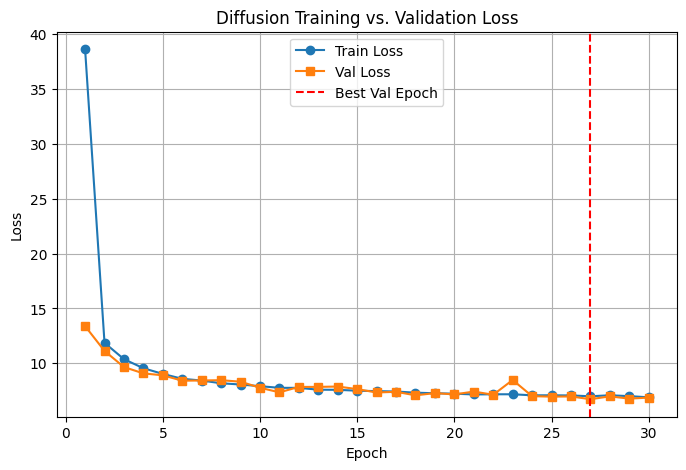

Training completed.
Best model loaded successfully.


In [77]:
# Instantiate the model train
model = Model(base_channels=512, time_emb_dim=64, n_resblocks=6).to(device)
print(f'Parameters count {count_parameters(model)}')
# train_diffusion(model, trainloader, valloader, num_epochs=30)
# print("Training completed.")

# Load best state_dict
model.load_state_dict(torch.load("./checkpoints_diffusion/best_model.pt"))
print("Best model loaded successfully.")


torch.Size([128, 1, 16, 16])
torch.Size([128, 1, 16, 16])


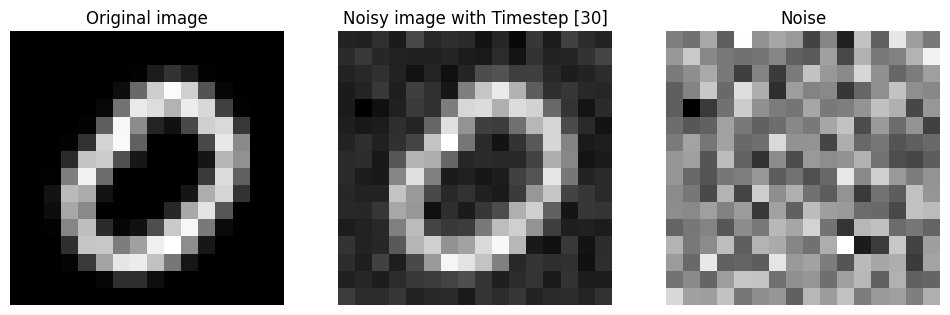

In [78]:
#  Check again that the data transformation is correct. 
for batch in trainloader:
    x_0 = batch[0].to(device)  # shape (1, 1, 16, 16)
    t = np.random.randint(0, T//20, size=(1,), dtype=np.int64)
    x_t, eps = diffusion_forward(x_0, t)
    print(x_t.shape)
    print(eps.shape)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    # Display the first image on the left subplot
    axes[0].imshow(x_0[0,0].to('cpu'), cmap='gray')
    axes[0].axis('off')  # Hide axes
    axes[0].set_title("Original image")

    # Display the second image on the right subplot
    axes[1].imshow(x_t[0,0].to('cpu'), cmap='gray')
    axes[1].axis('off')  # Hide axes
    axes[1].set_title(f'Noisy image with Timestep {t}')

     # Display the noise
    axes[2].imshow(eps[0,0].to('cpu'), cmap='gray')
    axes[2].axis('off')  # Hide axes
    axes[2].set_title(f'Noise')
    break


### 1.4: Visualizing the diffusion samples

Given the pretrained model, sample several images of digits. Visualize 4 samples for each digit class in the MNIST (i.e. classes 0-to-9, inclusive), and show the result in a 10x4 grid of images.

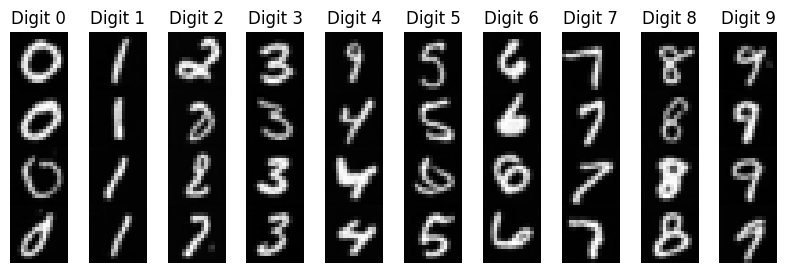

In [80]:
@torch.no_grad()
def sample_from_model(model: nn.Module, num_samples: int, digit_class: int):
    """
    Draw samples from the model for a given digit_class.
    We'll do the naive T-step reverse diffusion:
      x_T ~ N(0,I) -> x_{T-1} -> ... -> x_0
    """
    model.eval()
    x = torch.randn(num_samples, 1, H, W, device=device)  # x_T
    t_array = torch.arange(T-1, -1, -1, device=device)    # from T-1 down to 0
    y = torch.full((num_samples,), digit_class, device=device, dtype=torch.long)

    for i in range(T):
        t_cur = t_array[i]
        eps_pred = model(x, t_cur.repeat(num_samples), y)  # predicted noise

        alpha_t      = alpha_torch[t_cur]      # scalar
        alpha_bar_t  = alpha_bar_torch[t_cur]  # scalar
        beta_t       = beta_torch[t_cur]       # scalar

        alpha_t_     = alpha_t.view(-1,1,1,1)
        alpha_bar_t_ = alpha_bar_t.view(-1,1,1,1)

        # formula x_{t-1} = 1/sqrt(alpha_t)*(x_t - (1-alpha_t)/sqrt(1-alpha_bar_t)*eps_pred) + sqrt(beta_t)*z
        if t_cur > 0:
            z = torch.randn_like(x)
        else:
            z = 0.0

        eps = 1e-8
        x = (1.0 / torch.sqrt(alpha_t_ + eps)) * (
            x - ((1.0 - alpha_t_) / torch.sqrt(1.0 - alpha_bar_t_ + eps)) * eps_pred
            ) + torch.sqrt(beta_t + eps).view(-1,1,1,1) * z

    return x

plt.figure(figsize=(10, 3))
for digit_class in range(NUM_CLASSES):
    samples = sample_from_model(model, digit_class=digit_class, num_samples=4)
    samples = samples.detach().cpu() * 0.5 + 0.5
    samples_im = torch.cat([s[0] for s in samples], dim=0)
    subplot = plt.subplot(1, 10, digit_class + 1)
    subplot.imshow(samples_im, cmap='gray')
    subplot.axis('off')
    subplot.set_title(f'Digit {digit_class}')
plt.show()

## Part 2: Implementing Inpainting with Diffusion

Now that we have a trained diffusion model, let's implement inpainting using the model.
More specifically, given an image of a digit, we first mask a part of it. We then ask you to leverage the MNIST-trained diffusion model to inpaint the missing part so that the resulting image still looks like an image of the corresponding digit (the digit class is known as well).

You can select a method of your choice as long as you utilize the diffusion model you just trained.

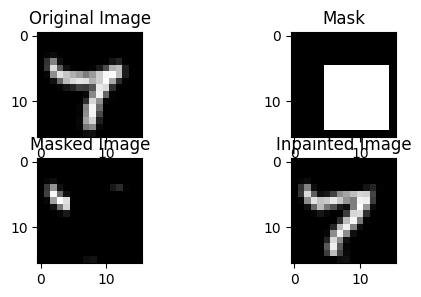

In [ ]:
def create_mask(image_size, box_size, position):
    """Create a binary mask for inpainting"""
    mask = torch.zeros((1, 1, image_size, image_size))
    x, y = position
    mask[:, :, y:y+box_size, x:x+box_size] = 1
    return mask

def inpaint_with_diffusion_model(
    model: nn.Module,
    image_masked: torch.Tensor,
    mask: torch.Tensor,
    digit_class: int,
) -> torch.Tensor:
    """
    Implement inpainting using the diffusion model

    Args:
        model: the diffusion model
        image_masked: the image to inpaint
        mask: binary mask where 1s are the masked region, and 0s are the known region
        digit_class: the digit class of the image
    """

    # 1) Make sure we have a batch dimension and channel dimension
    if image_masked.dim() == 2:
        # shape (H, W) => (1, 1, H, W)
        image_masked = image_masked.unsqueeze(0).unsqueeze(0)
        mask = mask.unsqueeze(0).unsqueeze(0)
    elif image_masked.dim() == 3:
        # shape (1, H, W) => (1, 1, H, W)
        image_masked = image_masked.unsqueeze(1)
        mask = mask.unsqueeze(1)

    image_masked = image_masked.to(device)
    mask = mask.to(device)               # shape (1,1,H,W)
    model.eval()

    # 2) Start from random noise for the entire image
    #    We’ll overwrite the known region each step anyway
    x = torch.randn_like(image_masked)   # shape (1,1,H,W)

    # 3) Reverse diffusion steps: T-1 ... 0
    for i in reversed(range(T)):
        t_cur = torch.tensor([i], device=device, dtype=torch.long)
        y     = torch.tensor([digit_class], device=device, dtype=torch.long)

        # a) predict noise with the model
        eps_pred = model(x, t_cur, y)   # shape (1,1,H,W)

        # b) retrieve alphas and betas for time i
        alpha_t     = alpha_torch[i]           # scalar
        alpha_bar_t = alpha_bar_torch[i]       # scalar
        beta_t      = beta_torch[i]            # scalar

        # c) sample noise for this step (except at t=0)
        if i > 0:
            z = torch.randn_like(x)
        else:
            z = 0.

        # d) compute x_{t-1} using the DDPM posterior mean + variance
        #    x_{t-1} = 1/sqrt(alpha_t)*(x_t - (1-alpha_t)/sqrt(1 - alpha_bar_t)*eps_pred) + sqrt(beta_t)*z
        # (add a small eps in sqrt() if needed to avoid nan)
        x_1 = (1.0 / torch.sqrt(alpha_t + 1e-8)) * (
                x - ( (1.0 - alpha_t) / torch.sqrt(1.0 - alpha_bar_t + 1e-8) ) * eps_pred
              ) + torch.sqrt(beta_t + 1e-8) * z

        # e) "inpaint" by restoring the known region from image_masked
        #    mask=1 means "to inpaint", so we keep x_1's new values there
        #    mask=0 means "known region", so we copy from the original image
        x = x_1 * mask + image_masked * (1 - mask)

    # at the end, x is shape (1,1,H,W)
    return x.squeeze(0)  # shape (1,H,W)

# take a random image from the validation set
image, label = valset[124]

# create a square mask
mask = create_mask(image.shape[1], 10, (5, 5))

# mask the image
image_masked = image * (1 - mask) + mask * (-1)

# inpaint the image
image_inpainted = inpaint_with_diffusion_model(
    model,
    image_masked,
    mask,
    label,
)

# show the known inputs and the inpainted image
plt.figure(figsize=(6, 3))

plt.subplot(2, 2, 1)
plt.title("Original Image")
orig = image.detach().cpu()  # shape (1,16,16)
orig = orig[0].clip(-1,1)*0.5+0.5  # => [0,1]
plt.imshow(orig, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Mask")
m = mask.detach().cpu()[0,0]
plt.imshow(m, cmap='gray')

plt.subplot(2, 2, 3)
plt.title("Masked Image")
masked_for_vis = image_masked.detach().cpu()[0,0].clip(-1,1)*0.5 + 0.5
plt.imshow(masked_for_vis, cmap='gray')

plt.subplot(2, 2, 4)
plt.title("Inpainted Image")
img = image_inpainted.detach()[0].cpu().clip(-1, 1) * 0.5 + 0.5
plt.imshow(img, cmap='gray')
plt.show()

# Part 3: Inpainting with SDS

The final task is the same as previous one. However, here we ask you to inpaint the image using a specific method: Score Distillation Sampling (SDS), as described in the DreamFusion paper available on arXiv: https://arxiv.org/abs/2209.14988

More specifically, we want to optimize a 2D image using SDS so that:
  - It's known (unmasked) part matches the given ground-truth image
  - It's unknown part gets feasibly inpainted so that the final image depicts the prescribed digit

IMPORTANT NOTE: Do NOT optimize a Neural Radiance Field (NeRF) as described in the original DreamFusion paper, but rather a sigle 2D image represented as a `H x W` tensor. The task is to use the SDS method to implement the optimization loop, not to reproduce the DreamFusion paper in its entirety.

Step 1/1000, Loss: 57.225257873535156
Step 101/1000, Loss: 3.0174245834350586
Step 201/1000, Loss: 0.010596291162073612
Step 301/1000, Loss: 0.0009145097574219108
Step 401/1000, Loss: 0.0033134205732494593
Step 501/1000, Loss: 0.06674454361200333
Step 601/1000, Loss: 0.02145366184413433
Step 701/1000, Loss: 0.09977973252534866
Step 801/1000, Loss: 0.14818796515464783
Step 901/1000, Loss: 0.0005894026253372431


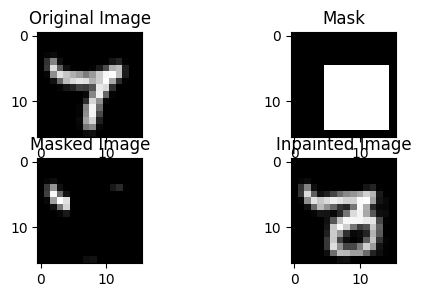

In [117]:
def sds_loss(
    model: nn.Module,
    opt_image: torch.Tensor,
    gt_image: torch.Tensor,
    mask: torch.Tensor,
    digit_class: int,
    num_optimization_steps: int = 1000,
):

    # A) Known region constraint:
    #    We strongly penalize deviation from ground truth in the unmasked region.
    #    mask=1 => region to inpaint, so we skip that. (1-mask)= known region.
    lambda_known = 100.0  # a weight to ensure known region is strongly preserved
    known_loss = ((opt_image - gt_image) * (1 - mask)).pow(2).mean()

    # B) Diffusion prior constraint (SDS):
    #    1) Pick a random timestep t
    #    2) Forward diffuse opt_image -> x_t
    #    3) Model predicts noise
    #    4) MSE in noise space => L_prior
    #    5) We do backprop w.r.t. opt_image
    B = opt_image.shape[0]  # typically 1
    t = torch.randint(0, T, (B,), device=opt_image.device)  # random step

    # forward diffuse
    x_t, eps = diffusion_forward(opt_image, t)  # same as your earlier function
    eps_pred = model(x_t, t, torch.tensor([digit_class], device=x_t.device))

    # The 'score distillation' trick is basically the MSE in noise space:
    # L_prior = E[ (eps_pred - eps)^2 ]
    # By taking gradient wrt opt_image, we nudge 'opt_image' to produce smaller MSE in noise space.
    prior_loss = F.mse_loss(eps_pred, eps)

    # Combine them
    # Weighted sum so we preserve known region while also shaping the masked region
    loss = lambda_known * known_loss + prior_loss
    return loss

def inpaint_with_sds(
    model: nn.Module,
    opt_image: torch.Tensor,
    gt_image: torch.Tensor,
    mask: torch.Tensor,
    digit_class: int,
    num_optimization_steps: int = 1000,
):
    # Reverse diffusion process with classifier-free guidance
    opt_image = torch.zeros_like(image_masked, device=device)
    gt_image = gt_image.to(device)
    mask = mask.to(device)
    opt_image.requires_grad = True
    optimizer = torch.optim.Adam([opt_image], lr=1e-2)
    for step in range(num_optimization_steps):
        optimizer.zero_grad()
        loss = sds_loss(model, opt_image, gt_image, mask, digit_class)
        if step % 100 == 0:
            print(f"Step {step+1}/{num_optimization_steps}, Loss: {loss.item()}")
        loss.backward()
        optimizer.step()
    return opt_image

optimized_image = inpaint_with_sds(model, image_masked, image, mask, label)

# show the known inputs and the inpainted image
plt.figure(figsize=(6, 3))

plt.subplot(2, 2, 1)
plt.title("Original Image")
orig = image.detach().cpu()  # shape (1,16,16)
orig = orig[0].clip(-1,1)*0.5+0.5  # => [0,1]
plt.imshow(orig, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("Mask")
m = mask.detach().cpu()[0,0]
plt.imshow(m, cmap='gray')

plt.subplot(2, 2, 3)
plt.title("Masked Image")
masked_for_vis = image_masked.detach().cpu()[0,0].clip(-1,1)*0.5 + 0.5
plt.imshow(masked_for_vis, cmap='gray')

plt.subplot(2, 2, 4)
plt.title("Inpainted Image")
img = optimized_image.detach().cpu()[0, 0].clip(-1, 1) * 0.5 + 0.5
plt.imshow(img, cmap='gray')
plt.show()

## Summary Report

### 1. Part 1: Simple Diffusion Model
- **Implementation**  
  I created a noise-prediction model using a series of **ResNet-style residual blocks** and **time/class embeddings** specifically for MNIST digits, exploring both **linear** and **cosine** \(\beta\)-schedules. Part of the implementation was inspired by the official DDPM repository ([lucidrains/denoising-diffusion-pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py)). Additionally, I used **data visualization** as a best practice to verify our input data—both before and after adding noise—and to quickly catch any potential problems during preprocessing.

- **Forward Diffusion**  
  I used the standard closed-form noising equation, 
  $$
  x_t = \sqrt{\bar{\alpha}_t}\,x_0 + \sqrt{1 - \bar{\alpha}_t}\,\epsilon.
  $$
- **Reverse (Denoising) Process**  
  The model predicts noise \(\epsilon\). I trained it with an MSE loss between the predicted noise and the true noise.  
- **Training & Validation**  
  - I discovered that training for roughly 30 epochs on MNIST helped the model produce recognizable conditional generations.  
  - I tracked validation loss for best-model checkpointing, although FID would have been ideal. MNIST’s single-channel format and small size complicate standard Inception-based FID scoring.  
  - Our initial attempt at a cosine schedule did not yield improved results with limited debugging time. Given more time, I would investigate this further.  
- **Outcome**  
  With sufficient epochs, the model produced recognizable MNIST digits under class conditioning.

### 2. Part 2: Inpainting with Diffusion
- **Goal**  
  Given a partially masked MNIST digit, fill in the missing region so it still resembles the original digit.  
- **Method: “Mask + Replace”**  
  In the reverse diffusion steps, I only update the masked region and restore the known region to its original pixel values after each step. This ensures the unmasked pixels remain unchanged.  
- **Notes**  
  - This approach was straightforward and required minimal debugging.  
  - Because the masked region is re-noised at each step but the unmasked region remains fixed, the final reconstruction aligns with the original digit in the unmasked area.

### 3. Part 3: Inpainting with SDS (Score Distillation Sampling)
- **Idea**  
  Instead of using direct reverse diffusion, I treat the masked image as a learnable parameter and optimize it directly via gradient-based updates.  
- **Implementation**  
  1. **Score Distillation Loss**: I combine:
     - A *known-region penalty* (`lambda_known` \(\times\) MSE of unmasked pixels vs. the ground truth).  
     - A *diffusion prior loss*, which is an MSE in noise space at a randomly sampled diffusion step \(t\).  
  2. **Optimization**: 
     - Each iteration, I noised the current image to \(x_t\), had the model predict \(\epsilon\), and took an MSE with the true noise. 
     - I backpropagated w.r.t. the masked image itself.  
     - Varying `lambda_known` (e.g., 10, 50, 100) controls how strictly I preserve the unmasked pixels versus allowing more freedom in the masked region. 
   
- **Note**  
  I found that **in the SDS inpainting** step, I had to set `lambda_known` to a relatively **large value** (around **100**) in order to strongly preserve the known (unmasked) region. Smaller values (like 10 or 20) allowed the diffusion prior to alter the originally unmasked pixels more than desired, while large values effectively locked the unmasked region and still let the model plausibly fill in the masked area. I believe this parts needs a more careful implementation and a deeper understanding from my side. Given more time I would consider going in the implementation of the original paper to better grasp it. 

